In [40]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from zlib import crc32
from pandas.plotting import scatter_matrix
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("/home/maria/Desktop/Maria_Shaukat_Admins/Oklahoma/jupyter/datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [2]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,'housing.tgz')
    print(tgz_path)
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(housing_path)
    housing_tgz.close()

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(HOUSING_PATH,'housing.csv')
    return pd.read_csv(csv_path)

In [169]:
fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)


/home/maria/Desktop/Maria_Shaukat_Admins/Oklahoma/jupyter/datasets/housing/housing.tgz


In [4]:
housing_data = load_housing_data(housing_path=HOUSING_PATH)

In [5]:
# See the top five rows of the dataframe
housing_data.head()
# Peak into the dataframe
housing_data.info()
# Peak inside a single category
housing_data['ocean_proximity'].value_counts()
# Peak inside the stats(min, max, quartiles) of the dataframe
housing_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


[]

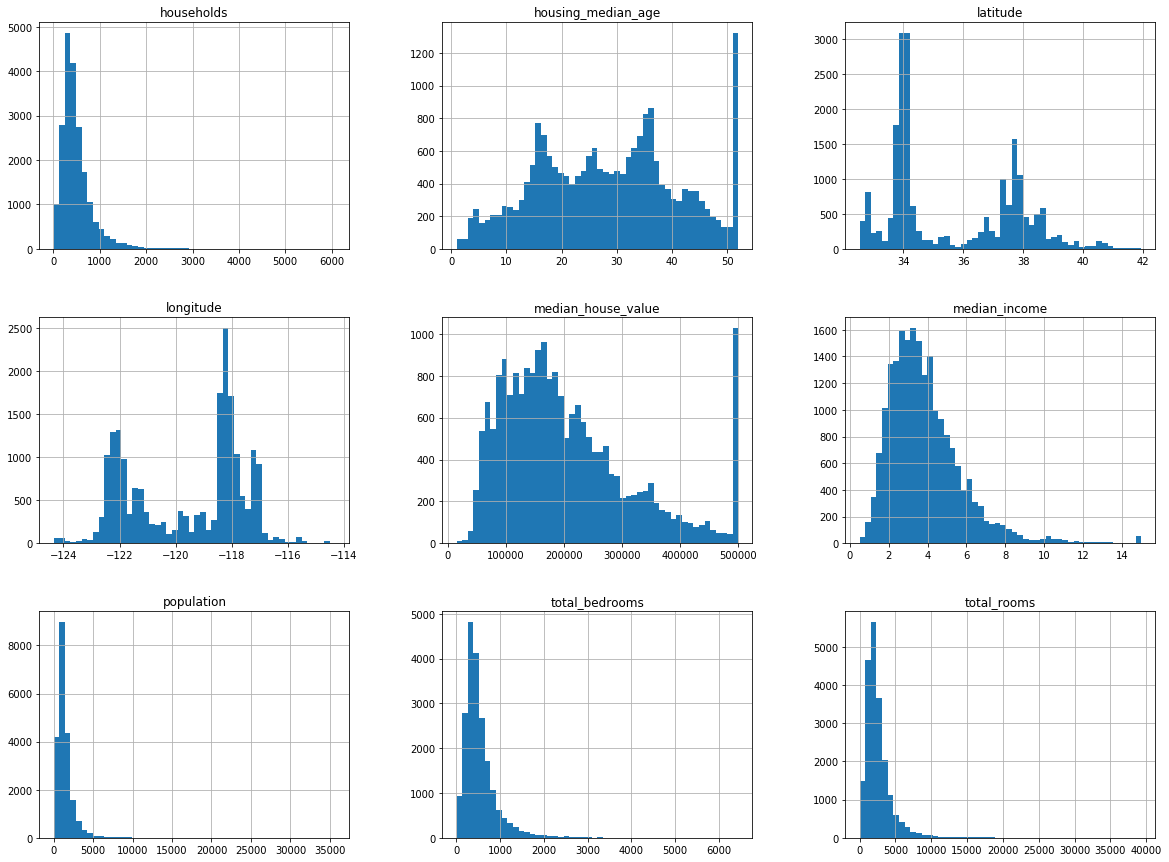

In [6]:
%matplotlib inline
housing_data.hist(bins=50, figsize=(20,15))
plt.plot()


In [7]:
# Seperate out the testing data
def split_train_test(data, test_ratio):
    assert(test_ratio<=1) # the ratio of data cannot be greater than 1
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data)) 
    test_data_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_data_size]
    train_indices = shuffled_indices[test_data_size:]
    return housing_data.iloc[train_indices], housing_data.iloc[test_indices] # iloc selects rows by given row numbers

In [8]:
train_df, test_df = split_train_test(housing_data, 0.2)
print(len(train_df), len(test_df))

16512 4128


In [9]:
# Seperate out the testing data by id
def test_set_check(identifier, test_ratio):
    verdict = crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32
    # crc32 generates a hash for identifier
    # & 0xffffff is to limit the hash to max value of hash
    # 2**32 is actually the maximum value of hash, which is also equal to 0xffffffff in hexadecimal
    return verdict
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data[~in_test_set], data[in_test_set]

In [10]:
#Lambda functions (not directly related to this example)
inp = 1
x = lambda a: a+10 # x will not be a variable but a lambda function
print(x(inp))

11


In [11]:
test_ratio =  0.2
#housing_data_with_id = housing_data.reset_index() # It will add a column of indices to the data frame with name 'index'
housing_data['id'] = housing_data['longitude']*1000 + housing_data['latitude']
train_data_random, test_data_random = split_train_test_by_id(housing_data, test_ratio, 'id')
test_data_random.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


[]

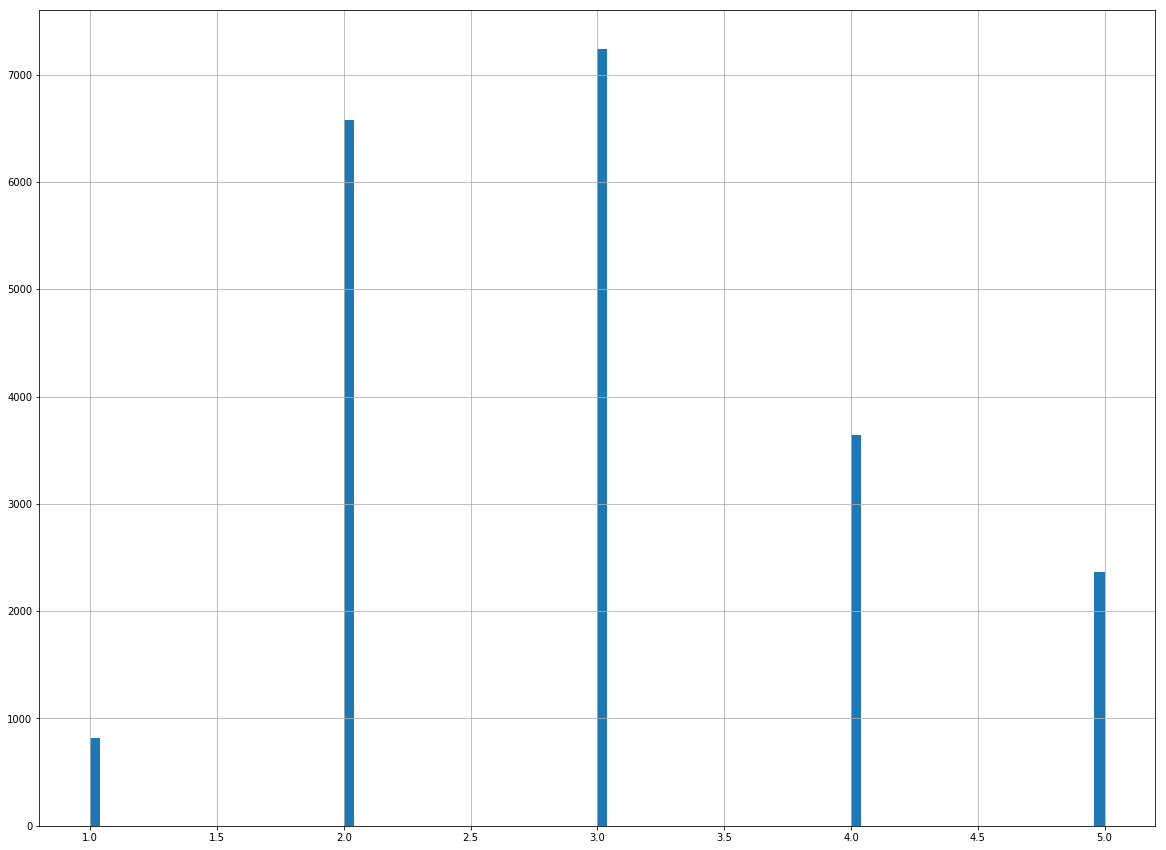

In [12]:
housing_data["income_cat"] = np.ceil(housing_data['median_income']/1.5) # divide by 1.5 to reduce the magnitude of size of income values without loosing the data distribution
housing_data['income_cat'].where(housing_data['income_cat']<5, 5.0, inplace=True)
housing_data["income_cat"].hist(bins = 100, figsize=(20,15))
plt.plot()


[17606 18632 14650 ... 13908 11159 15775] [ 5241 10970 20351 ...  4019 12107  2398]


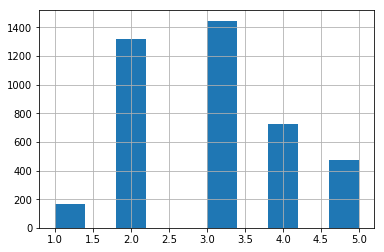

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # this is valuable algo to generate sets for cross validation
for train_index, test_index in split.split(housing_data, housing_data['income_cat']): # because n_splits=1 in las line, this for loop will run once 
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]
    print(train_index,test_index)

strat_test_set['income_cat'].hist() # Notice that the histogram of income_cat in strat_test_set and complete housing_data has similar distribution
plt.show()

In [14]:
#Reproducing the data in Fig 2-10: Sampling bias comparison of stratified versus purely random sampling
sampling_error = pd.DataFrame(columns=None) # created an empty dataframe
sampling_error['Overall'] = housing_data["income_cat"].value_counts()/len(housing_data)*1000
sampling_error['Stratified'] = strat_test_set['income_cat'].value_counts()/len(strat_test_set)*1000
train_set_random, test_set_random = split_train_test(housing_data, test_ratio) # this is modified housing_data with income_cat but without id
sampling_error['Random'] = test_set_random['income_cat'].value_counts()/len(test_set_random)*1000
sampling_error['Strat.%Error'] = ((sampling_error['Stratified']-sampling_error['Overall'])/sampling_error['Overall'])*100
sampling_error['Rand.%Error'] = ((sampling_error['Random']-sampling_error['Overall'])/sampling_error['Overall'])*100

sampling_error

,Overall,Stratified,Random,Strat.%Error,Rand.%Error
3.0,350.581395,350.532946,358.527132,-0.013820,2.266446
2.0,318.846899,318.798450,324.370155,-0.015195,1.732260
4.0,176.308140,176.356589,167.393411,0.027480,-5.056334
5.0,114.437984,114.583333,109.496124,0.127011,-4.318374
1.0,39.825581,39.728682,40.213178,-0.243309,0.973236


In [15]:
# return the housing_data to normal by droping income_cat
strat_test_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.head()
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,-121852.71
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,-121892.95
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,-117167.23
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,-119573.69
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,-118555.77


In [74]:
# return the housing_data to normal by droping income_cat
strat_train_set.drop('id', axis=1, inplace=True)
strat_train_set.head()
housing_data.drop('id', axis = 1, inplace=True)
strat_test_set.drop('id', axis =1, inplace=True)

(array([-126., -124., -122., -120., -118., -116., -114., -112.]),
 <a list of 8 Text xticklabel objects>)

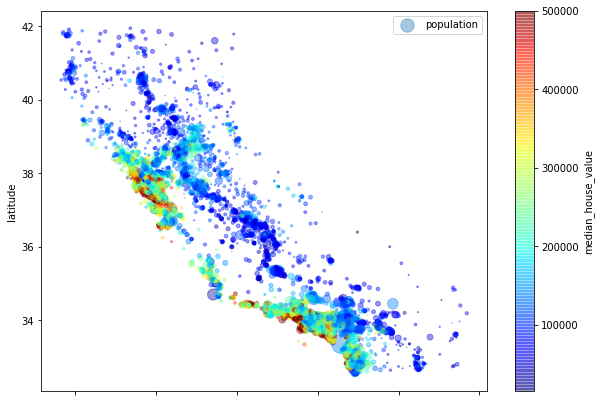

In [17]:
# DATA EXPLORATION
housing_cp = strat_train_set.copy()
housing_cp
#housing_cp.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
housing_cp.describe() # to find out if there is scaling needed for population and median_house_value columns before plotting
# see, for population, max=35682 and min=3, so we can do  scalling of 10 or 100 to plot it as radius?
housing_cp.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7),
                s=housing_cp["population"]/100, label="population", c="median_house_value", 
                cmap=plt.get_cmap("jet"), colorbar=True, )
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=90)
# Don't know why label and ticks on x-axis are not visible


In [18]:
#Looking for Co-relations
corr_matrix = housing_cp.corr() # values of correlation co-efficients will be from -1 to 1
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6eac9446d8>,
      dtype=object)

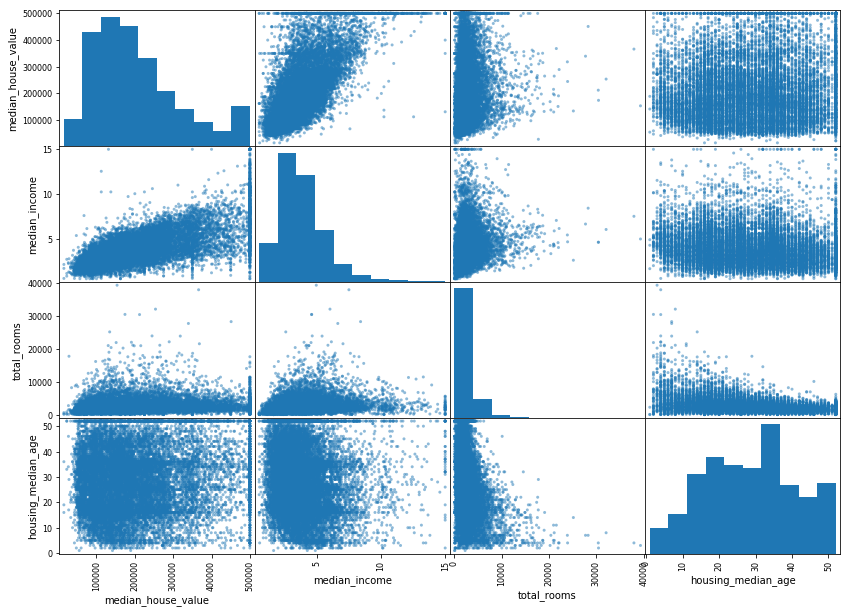

In [19]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing_cp[attributes], figsize=(14,10))

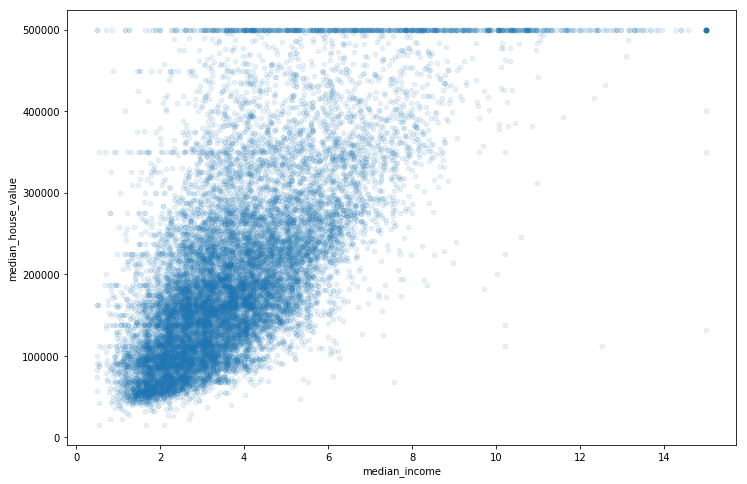

In [20]:
housing_cp.plot(kind='scatter', x='median_income', y='median_house_value', figsize=(12,8), alpha=0.1)

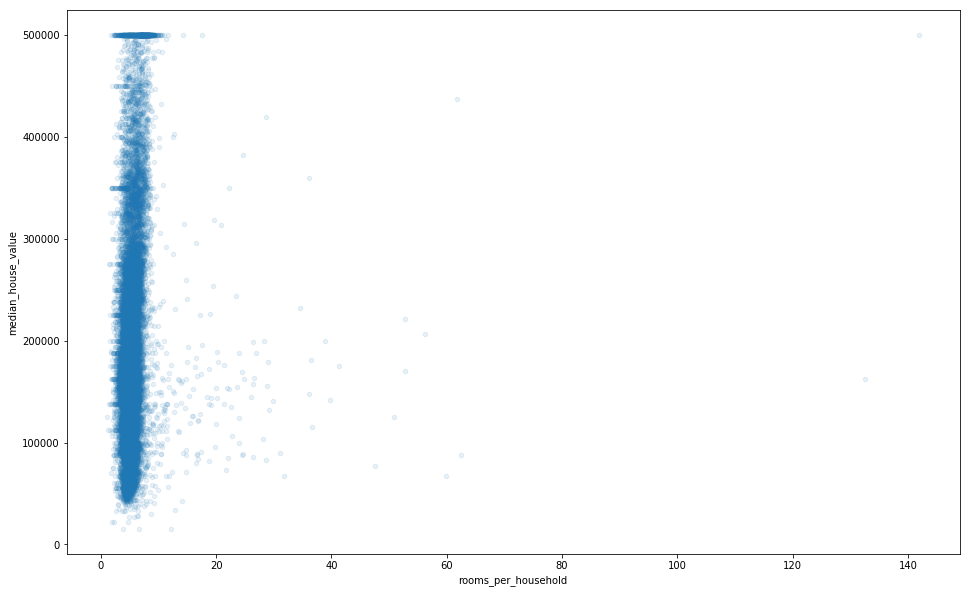

In [21]:
housing_cp['rooms_per_household'] = housing_cp['total_rooms']/housing_cp['households']
housing_cp.plot(kind='scatter',  x='rooms_per_household', y='median_house_value', figsize=(16,10) , alpha =0.1)

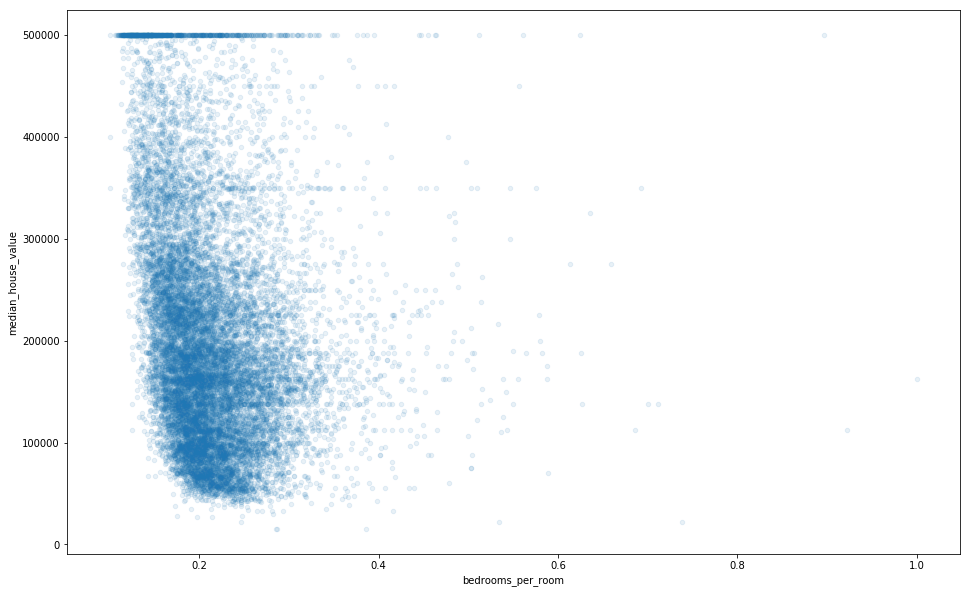

In [22]:
housing_cp['bedrooms_per_room'] = housing_cp['total_bedrooms']/housing_cp['total_rooms']
housing_cp.plot(kind='scatter',  x='bedrooms_per_room', y='median_house_value', figsize=(16,10) , alpha = 0.1)

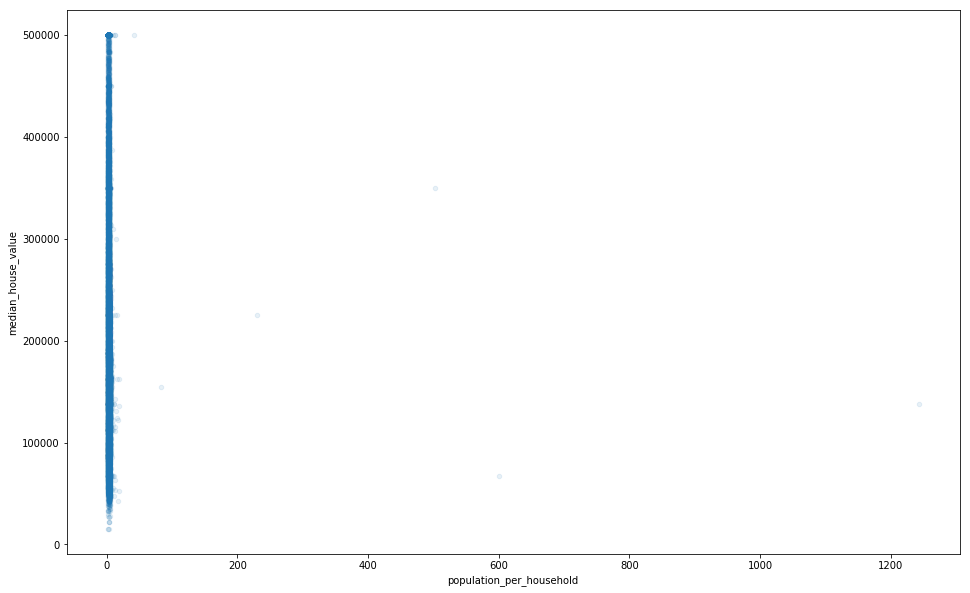

In [23]:
housing_cp["population_per_household"] = housing_cp["population"]/housing_cp["households"]
housing_cp.plot(kind='scatter',  x='population_per_household', y='median_house_value', figsize=(16,10) , alpha=0.1)

In [24]:
corr_matrix = housing_cp.corr() # values of correlation co-efficients will be from -1 to 1
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [26]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_labels.head() 
housing.info() # Notice that total bedrooms has 16354 values instead of 16512

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [27]:
housing_cp = housing_data.copy()
housing_temp = housing_cp.dropna(subset=['total_bedrooms'])
housing_temp.info() # Notice the total number of rows in the dataframe have been reduced
housing_temp = housing_cp.drop('total_bedrooms', axis=1)
housing_temp.info()
med = housing_cp['total_bedrooms'].median() # 433.0, save this for later
housing_cp['total_bedrooms'].fillna(med, inplace=True)
housing_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 11 columns):
longitude             20433 non-null float64
latitude              20433 non-null float64
housing_median_age    20433 non-null float64
total_rooms           20433 non-null float64
total_bedrooms        20433 non-null float64
population            20433 non-null float64
households            20433 non-null float64
median_income         20433 non-null float64
median_house_value    20433 non-null float64
ocean_proximity       20433 non-null object
income_cat            20433 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
population            20640 non-null float64
households

In [28]:

# copy of data without ocean proximity
housing_num = housing.drop('ocean_proximity', axis=1)
imputer = SimpleImputer(strategy='median') # In Sklearn: SimpleImputer is an estimator
# imputer is an instance of the estimator SimpleImputer
# You pass the hyperparameters of the estimator to the constructor
imputer.fit(housing_num)
imputer.statistics_ # You can access the learned parameters of the estimator with a . and _
x = imputer.transform(housing_num) # returns a numpy array
housing_tr = pd.DataFrame(x, columns=housing_num.columns)
housing_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [29]:
# Handling Text and Categorical Attributes
housing_cat = housing[['ocean_proximity']] 
# housing[ocean_proximity] gives pandas.core.series.Series object
# housing[ocean_proximity] gives pandas.core.frame.DataFrame object
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [30]:
one_hot_encoder = OneHotEncoder()
cat_encoded = one_hot_encoder.fit_transform(housing_cat) # returns a Scipy sparse matrix
cat_encoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [31]:
# Custom Transformers

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):# adding two base classes 
    def __init__(self, add_bedrooms_per_room = True):
            self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, x, y=None):
        return self
    def transform(self, x, y=None): # x is just an array not a dataframe
        rooms_per_household = x[:,rooms_ix]/x[:,households_ix]
        population_per_household = x[:,population_ix]/x[:,households_ix]
        if self.add_bedrooms_per_room == True:
            bedrooms_per_rooms = x[:,bedrooms_ix]/x[:,rooms_ix]
            return np.c_[x, rooms_per_household, population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[x, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values) # why values, because need to pass array
# returns a numpy array, not dataframe


In [32]:
# Sklearn Pipelines

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # returns a numpy array, not dataframe... input numpy array or dataframe
    ('customAdder', CombinedAttributesAdder()), # returns a numpy array, not dataframe... input numpy arrays
    ('standardScaler', StandardScaler()) # returns a numpy array, not dataframe... input numpy array or dataframe
])

housing_cp_tr = num_pipeline.fit_transform(housing_num)
housing_cp_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [33]:
# Column Transformer
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) # returns a list of column names
print(num_attribs)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num_trans',num_pipeline,num_attribs),
    ('cat_trans',OneHotEncoder(),cat_attribs)
], remainder='drop') # the remainder can be 'passthrough' or 'drop'


housing_prepared = full_pipeline.fit_transform(housing)


['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [34]:
# Training and Evaluating on the Training Set

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
# Training and Evaluating on the Training Set

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [36]:
# test the model, training set error

some_data =  housing[0:10]
some_labels = housing_labels.values[0:10]
some_data_tr = full_pipeline.transform(some_data)
predictions = lin_reg.predict(some_data_tr)
print(predictions)
print(some_labels)

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels.values, housing_predictions)
rmse = np.sqrt(mse)
print('linear regression training error:', rmse)
predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels.values, predictions)
tree_rmse = np.sqrt(tree_mse)
print('decision tree regressor training error: ', tree_rmse)

[210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879 154295.07624519 426711.9315643  228002.94602374
 139801.43738593  30128.00152011]
[286600. 340600. 196900.  46300. 254500. 127900. 500001. 140200.  95000.
 500001.]
linear regression training error: 68628.19819848923
decision tree regressor training error:  0.0


In [37]:
# Better Evaluation Using Cross-Validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print('scores', rmse_scores)
print('scores mean', rmse_scores.mean())
print('scores standard deviation', rmse_scores.std())

scores [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
scores mean 70666.74616904806
scores standard deviation 2928.322738055112


In [38]:
# Better Evaluation Using Cross-Validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print('scores', rmse_scores)
print('scores mean', rmse_scores.mean())
print('scores standard deviation', rmse_scores.std())

scores [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
scores mean 69052.46136345083
scores standard deviation 2731.674001798349


In [39]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels.values, forest_predictions)
forest_train_err = np.sqrt(mse)
print('Random forest train err: ', forest_train_err)
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv=10)
cv_scores = np.sqrt(-scores)
print('Random forest CV err: ', cv_scores, 'mean:', cv_scores.mean(), 'standard deviation: ', cv_scores.std())

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random forest train err:  22256.354579885898
Random forest CV err:  [52868.21871547 49194.92340594 51713.77716246 55012.10310441
 50973.88861214 55990.4479905  52298.68285092 50953.09058463
 54428.48087563 53461.73225682] mean: 52689.53455589254 standard deviation:  1980.36257012708


In [43]:
from sklearn.model_selection import GridSearchCV

params_grid = [
                {'n_estimators' : [3,10,30], 'max_features' : [2,4,6,8]},
                {'bootstrap':[False], 'n_estimators' : [3,10], 'max_features' : [2,3,4]}] # list of dictionaries

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, params_grid, cv=5, scoring = 'neg_mean_squared_error',
                           return_train_score =True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [51]:
grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_
for mean_test_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_test_score), params)
    

64801.170154818494 {'max_features': 2, 'n_estimators': 3}
54948.53717321489 {'max_features': 2, 'n_estimators': 10}
52540.8379642724 {'max_features': 2, 'n_estimators': 30}
60307.58503816557 {'max_features': 4, 'n_estimators': 3}
53172.61880128131 {'max_features': 4, 'n_estimators': 10}
50688.897429669116 {'max_features': 4, 'n_estimators': 30}
59475.648566696575 {'max_features': 6, 'n_estimators': 3}
52753.89149879461 {'max_features': 6, 'n_estimators': 10}
50228.00307613253 {'max_features': 6, 'n_estimators': 30}
58876.57766482005 {'max_features': 8, 'n_estimators': 3}
51876.79145454878 {'max_features': 8, 'n_estimators': 10}
49829.439710525075 {'max_features': 8, 'n_estimators': 30}
62554.95639445695 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54568.73656576234 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61299.215316288326 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52305.70213175205 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [54]:
import sklearn 
sklearn.__version__ # since version < 0.22 so the default n_estimators in RandomForestRegressor is 10
# for version >= 0.22 the default is 100

'0.20.3'

In [67]:
importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(full_pipeline.named_transformers_['cat_trans'].categories_[0])
attribs = num_attribs+extra_attribs+cat_one_hot_attribs
print(attribs)
sorted(zip( importances, attribs), reverse=True) 
# sorted() is a function, it does not change the input
# sort() is a method, it changes the input

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


[(0.34380419345656954, 'median_income'),
 (0.14802346967467553, 'INLAND'),
 (0.1135573278484488, 'pop_per_hhold'),
 (0.07299409175896937, 'longitude'),
 (0.07179693859633178, 'bedrooms_per_room'),
 (0.07122919538861451, 'latitude'),
 (0.06260763986431564, 'rooms_per_hhold'),
 (0.04121991149129799, 'housing_median_age'),
 (0.016234526038162302, 'total_rooms'),
 (0.015502490854643194, 'population'),
 (0.014897632887692063, 'total_bedrooms'),
 (0.013689576033976036, 'households'),
 (0.009536143655211021, '<1H OCEAN'),
 (0.003214574271188478, 'NEAR OCEAN'),
 (0.0016361699519094703, 'NEAR BAY'),
 (5.611822799432693e-05, 'ISLAND')]

In [77]:
# Evaluate Your System on the Test Set

final_model = grid_search.best_estimator_

housing_test = strat_test_set.drop('median_house_value', axis = 1)
housing_test_labels = strat_test_set['median_house_value'].copy()
housing_test_prepared = full_pipeline.transform(housing_test)

predictions = final_model.predict(housing_test_prepared)
mse = mean_squared_error(housing_test_labels.values, predictions)
rmse = np.sqrt(mse)
print('Test data: ', rmse)


Test data:  47791.81522863021
